![alt text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

# Éléments Logiciels pour le Traitement des Données Massives
## " Neural Network Parallelization " - Hicham EL BOUKKOURI

#### Python version :

In [1]:
import sys
print(sys.version)

3.6.3 (default, Nov  6 2017, 23:09:57) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.38)]


#### Used packages :

In [2]:
import time
import random
from math import exp
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
from sklearn.datasets import make_regression

import multiprocessing as mp
from functools import partial

import seaborn as sns
from matplotlib import pylab, pyplot as plt

#### Matplotlib settings :

In [3]:
sns.set_style("whitegrid")
sns.set_context("talk")
pylab.rcParams["figure.figsize"] = (18, 8)

#### Disabling warnings

In [4]:
import warnings
warnings.filterwarnings(action="ignore")

# Context

**Neural Networks** are one of the most used **Machine Learning** models today because of their ability to automatically learn very complex **features**. Thanks to these networks, **feature engineering** becomes unnecessary and a very **high performance** can usually be achieved using a very **simple model**.

There are many things that can be done to **improve a basic Neural Network**. In terms of **speed** and efficiency, an intuitive thing to do is to allow the Network to run in **parallel**. But how exactly can we do this ? In fact, there are many ways to parallelize an algorithm, so how can we go about parallelizing a **Neural Network** ?

We will explore two simple ways to parallelize a Neural Network :
- Parallelizing the **computations** occuring in the network.
- Parallelizing the **learning** steps.

# Part I : Parallelizing the computations

In order to parallelize the **computations** of a Neural Network, a brute force approach is to parallelize each and every **matrix multiplication** that is used inside the Neural Network. To do so, we start by defining the **standard matrix multiplication** : $\left[A.B\right]_{ij} = \sum_{k}a_{ik}b_{jk}$

In [5]:
def multiply(A, B):
    """Standard matrix multiplication."""
    matrix = []
    for i in range(len(A)):
        row = []
        for j in range(len(B[0])):
            s = 0.
            for k in range(len(A[0])):
                s += A[i][k] * B[k][j]
            row.append(s)
        matrix.append(row)
    return matrix

#### Matrix multiplication test :

In [6]:
A = [[0, 0, 0],
     [1, 0, 0]]

B = [[1, 2],
     [3, 4],
     [5, 6]]

print(np.array(multiply(A, B)))

[[ 0.  0.]
 [ 1.  2.]]


Everything seems to work fine.
***

Now, in order to **parallelize** the computations happening in the Neural Network we have to come up with parallelized versions of the previous matrix multiplication. There are two simple ways to do it (the more sophisticated methods rely on the multiplication of submatrices in parallel) :
- computing **each element of the resulting matrix** in parallel, we'll call this a ***full parallel*** multiplication.
- computing **each row of the resulting matrix** in parallel, we'll call this ***row parallel*** multiplication.

Let's just assume for now that parallelizing on the columns is the same as doing it on the rows.

In practive we will need to define a **job** that each of the available processses will have to do. In the case of the **full parallel** multiplication, this job will be to compute **an element of the new matrix**. Similarly, in the case of a **row parallel** multiplication, the job will be to compute **a row of the new matrix**.

In [7]:
def row_parallel_job(i, A, B):
    row = []
    for j in range(len(B[0])):
        s = 0.
        for k in range(len(A[0])):
            s += A[i][k] * B[k][j]
        row.append(s)
    return row


def row_parallel_multiply(A, B, pool):
    """Computes each row of the matrix multiplication in parallel."""
    partial_job = partial(row_parallel_job, A=A, B=B)
    return pool.map(partial_job, range(len(A)))


def column_parallel_job(i, A, B):
    column = []
    for j in range(len(A)):
        s = 0.
        for k in range(len(A[0])):
            s += A[j][k] * B[k][i]
        column.append(s)
    return column

def transpose(A):
    """Computes the transpose of a matrix."""
    return [[A[i][j] for i in range(len(A))] for j in range(len(A[0]))]

def column_parallel_multiply(A, B, pool):
    """Computes each column of the matrix multiplication in parallel."""
    partial_job = partial(column_parallel_job, A=A, B=B)
    return transpose(pool.map(partial_job, range(len(B[0]))))


def full_parallel_job(idx, A, B):
    i, j = idx
    s = 0.
    for k in range(len(A[0])):
        s += A[i][k] * B[k][j]
    return (i, j), s


def full_parallel_multiply(A, B, pool):
    """Computes each element of the matrix multiplication in parallel."""
    indices = [(i, j) for i in range(len(A)) for j in range(len(B[0]))]
    matrix = [[None for j in range(len(B[0]))] for i in range(len(A))]
    
    partial_job = partial(full_parallel_job, A=A, B=B)
    res = pool.map(partial_job, indices)

    for idx, v in res:
        i, j = idx
        matrix[i][j] = v
    return matrix

#### Comparison 1 : Matrix multiplication

Now let's play with some random matrices and **check if the parallel multiplications are indeed quicker than a standard matrix multiplication**. We define a function that computes many multiplications and records the **elapsed times** and **speedups** for each kind of multiplication then plots the results :

In [8]:
def random_matrix(n_rows, n_cols):
    """Creates a random matrix of integers x, where -10 < x < 10"""
    matrix = [
        [random.randint(-10, 10) for _ in range(n_cols)]
        for _ in range(n_rows)
    ]
    return matrix


def compare_parallel(max_size=100, A_rows=None, A_cols=None,
                     B_rows=None, B_cols=None):    
    """
    Plots the elapsed time as well as speedups of parallel
    and non parallel matrix multiplications while increasing the matrix size.     
    If any of the dimensions is an integer, the dimension is fixed.
    """
    
    np.random.seed(0)
    
    # Creating a pool of all available processors:
    n_CPUs = mp.cpu_count()
    pool = mp.Pool(processes=n_CPUs)
    print("This machine has {} CPUs".format(n_CPUs))

    # Arrays for plots:
    non_parallel_array = []
    row_parallel_array = []
    column_parallel_array = []
    full_parallel_array = []
    row_speedup_array = []
    column_speedup_array = []
    full_speedup_array = []
    for i in tqdm(range(10), desc="iteration"):
        
        non_parallel = []
        row_parallel = []
        column_parallel = []
        full_parallel = []
        row_speedup = []
        column_speedup = []
        full_speedup = []
        grid = np.logspace(0, int(np.log10(max_size)), 10)
        for n in grid:

            # Create random matrices:
            A = random_matrix(A_rows if A_rows else int(n),
                              A_cols if A_cols else int(n))
            B = random_matrix(B_rows if B_rows else int(n),
                              B_cols if B_cols else int(n))

            # Compare execution time for both parallel and non-parallel versions:
            t = time.time()
            _ = multiply(A, B)
            dt = time.time() - t
            non_parallel.append(dt)

            t = time.time()
            _ = row_parallel_multiply(A, B, pool=pool)
            dt_parallel = time.time() - t
            row_parallel.append(dt_parallel)
            row_speedup.append(dt/dt_parallel)

            t = time.time()
            _ = column_parallel_multiply(A, B, pool=pool)
            dt_parallel = time.time() - t
            column_parallel.append(dt_parallel)
            column_speedup.append(dt/dt_parallel)
            
            t = time.time()
            _ = full_parallel_multiply(A, B, pool=pool)
            dt_parallel = time.time() - t
            full_parallel.append(dt_parallel)
            full_speedup.append(dt/dt_parallel)

        non_parallel_array.append(non_parallel)
        row_parallel_array.append(row_parallel)
        column_parallel_array.append(column_parallel)
        full_parallel_array.append(full_parallel)
        row_speedup_array.append(row_speedup)
        column_speedup_array.append(column_speedup)
        full_speedup_array.append(full_speedup)

    # Plot results
    plt.subplot(211)
    plt.title("Elapsed time")
    sns.tsplot(non_parallel_array, time=grid, condition="standard")
    sns.tsplot(row_parallel_array, time=grid, color='green', condition="row parallel")
    sns.tsplot(column_parallel_array, time=grid, color='orange', condition="column parallel")
    sns.tsplot(full_parallel_array, time=grid, color='red', condition="full parallel")
    plt.xlabel("matrix size")
    plt.legend()

    plt.subplot(212)
    plt.title("Speedup")
    plt.axhline(y=1, ls='--', alpha=0.5, label="standard")
    sns.tsplot(row_speedup_array, time=grid, color='green', condition="row parallel")
    sns.tsplot(column_speedup_array, time=grid, color='orange', condition="column parallel")
    sns.tsplot(full_speedup_array, time=grid, color='red', condition="full parallel")
    plt.xlabel("matrix size")
    plt.ylim(0, 2.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    pool.close()

A first scenario is an **(N x N) squared matrix** multiplication :

iteration:   0%|          | 0/10 [00:00<?, ?it/s]

This machine has 4 CPUs


iteration: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


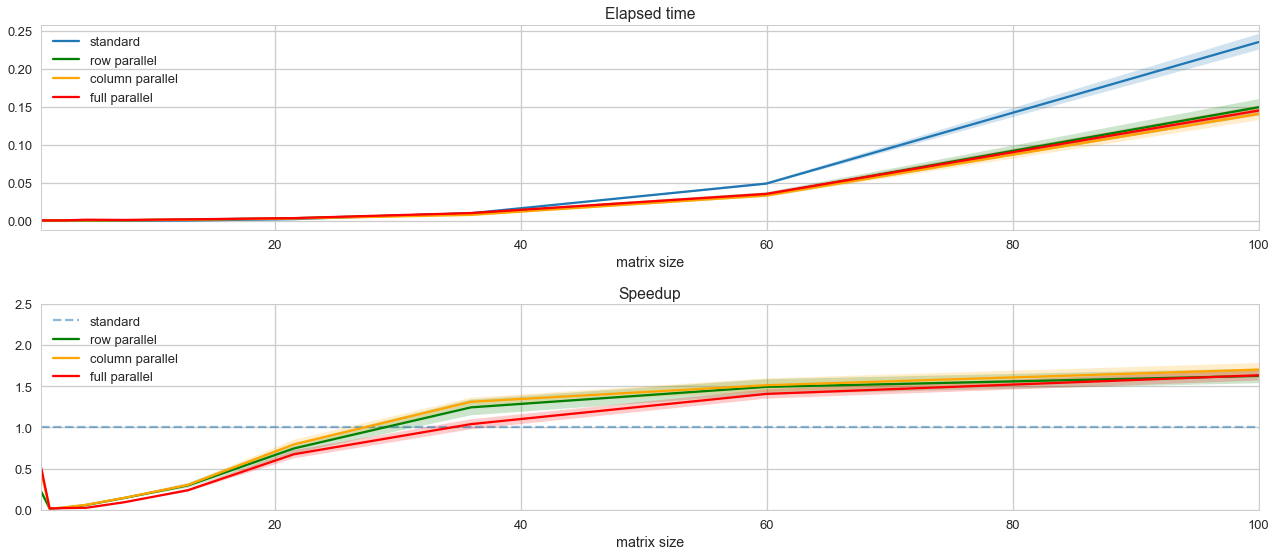

In [9]:
compare_parallel()

We see that for **small matrices**, the parallel version are **slower than a standard matrix multiplication**. But as the **matrix size increases**, the parallel versions take indeed less time to compute the result. The bad performance for small matrix sizes is probably due to the **time that is lost spawning new processes**.

Let's now see how the parallel multiplications behave when multiplying a **(1 x N) row vector by an (N x N) matrix** :

iteration:   0%|          | 0/10 [00:00<?, ?it/s]

This machine has 4 CPUs


iteration: 100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


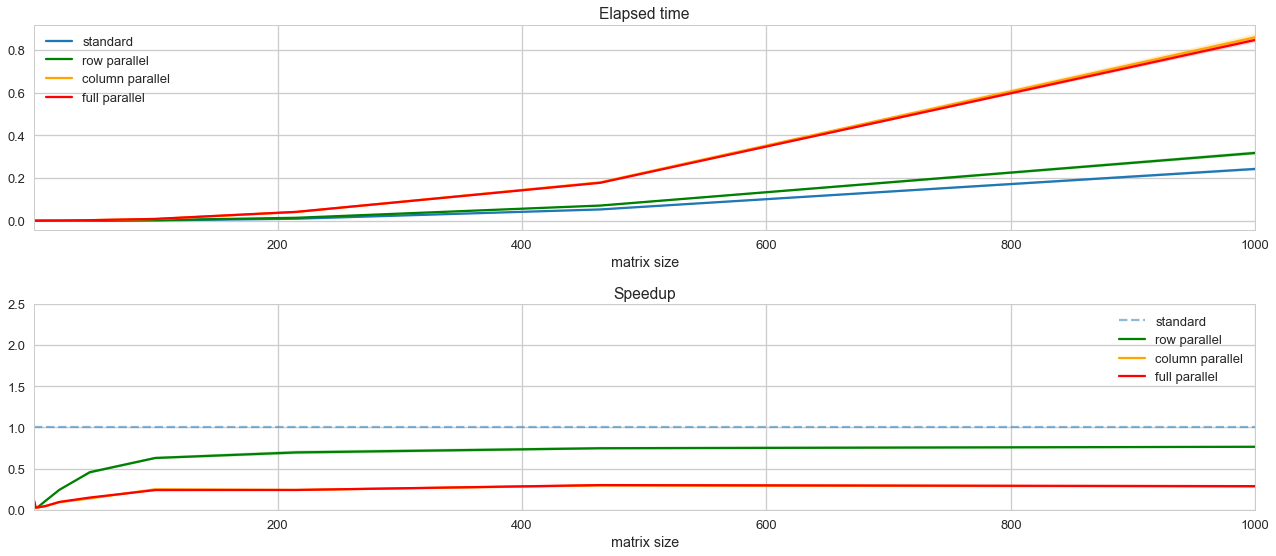

In [10]:
compare_parallel(max_size=1000, A_rows=1)

In this case, **all parallel versions are slower than the standard multiplication**. We can also see that the **row parallel** multiplication that should be equivalent to the standard multiplication, despite being the fastest parallel version, still **isn't as fast as the standard baseline**. This means that **some time is indeed lost when spawning processes**. The exact same thing happens when multiplying an **(N x N) matrix by a (N x 1) column vector**, the only thing that changes is that the fastest parallel version becomes the columns parallel multiplication :

iteration:   0%|          | 0/10 [00:00<?, ?it/s]

This machine has 4 CPUs


iteration: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it]


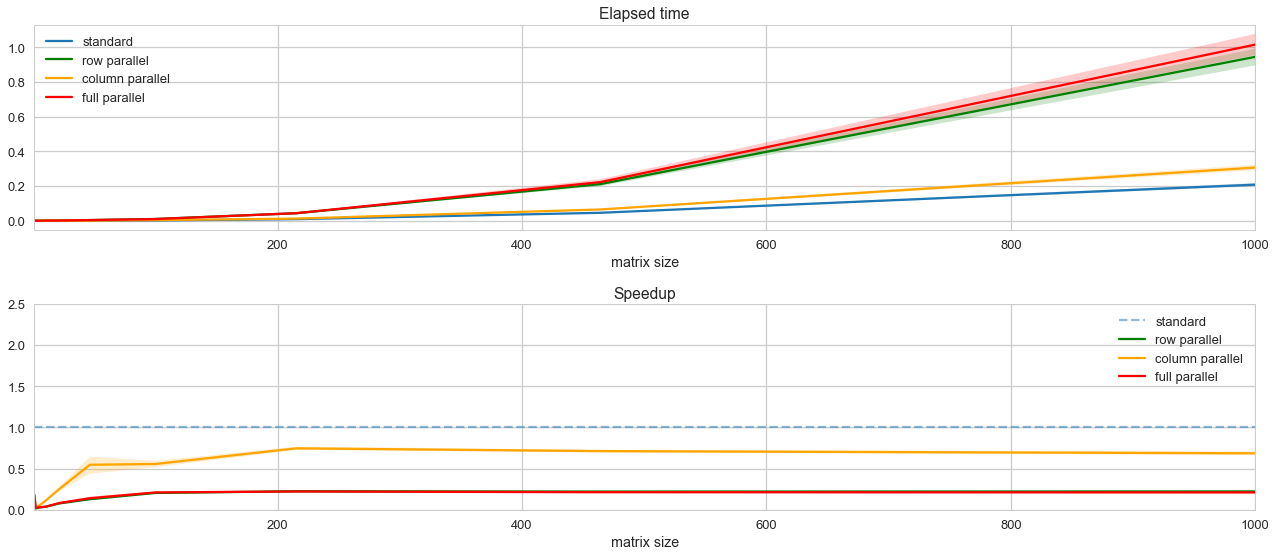

In [11]:
compare_parallel(max_size=1000, B_cols=1)

Another scenario is the scalar product of an **(N x 1) column vector by a (1 x N) row vector** :

iteration:   0%|          | 0/10 [00:00<?, ?it/s]

This machine has 4 CPUs


iteration: 100%|██████████| 10/10 [00:00<00:00, 12.59it/s]


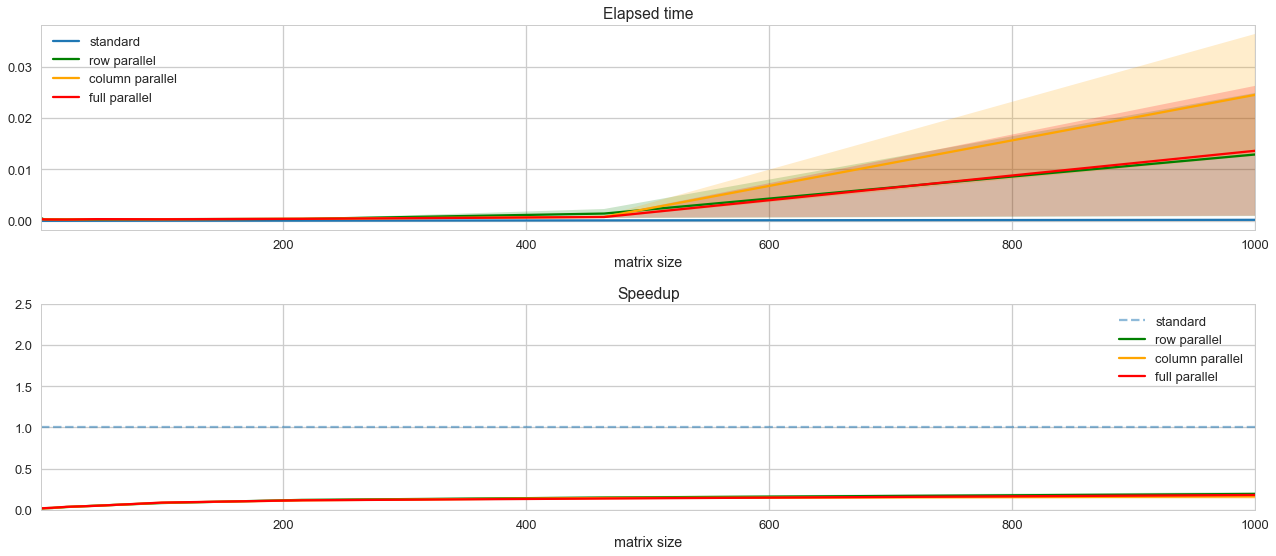

In [12]:
compare_parallel(max_size=1000, A_rows=1, B_cols=1)

Once again the parallel versions are slow. So, **this kind of parallelization wouldn't work for dot products**.

Last case, the multiplication of a **(1 x N) row vector by an (N x 1) column vector** :

iteration:   0%|          | 0/10 [00:00<?, ?it/s]

This machine has 4 CPUs


iteration: 100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


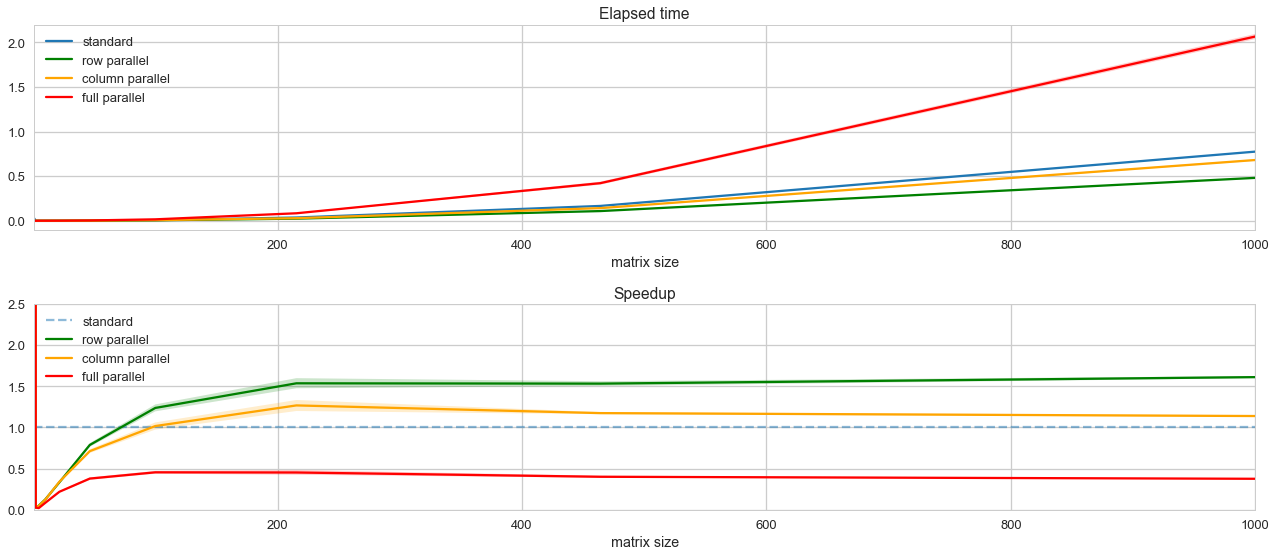

In [13]:
compare_parallel(max_size=1000, A_cols=1, B_rows=1)

Now the **row and column parallel** versions seem to be **faster** than the standard matrix multiplication. Recalling the previous results, it seems that the parallel versions are faster whenever the result of the multiplication is a matrix rather than vector.

#### Comparison 2 : Neural Network

Based on our results, we can try to guess how a **Neural Network** using this kind of **parallelization** would behave. For a **small number of units** in each layer, **the standard neural network should be quicker**, but as the layer size will **increase**, **the parallel versions would get close then improve over the baseline**.

To check if our intuition is true, we will be using a simple **Feed Forward Neural Network** with **an input layer**, a single **hidden layer** and **an output layer** :

In [14]:
def sigmoid(x, deriv=False):
    """Sigmoid activation function. If deriv=True, this returns the derivative."""
    if deriv:
        return [[value * (1 - value) for value in row] for row in x]
    else:
        return [[1 / (1 + exp(-value)) for value in row] for row in x]


class NeuralNetwork:
    """Standard Feed Forward Neural Network with a single hidden layer."""
    
    def __init__(self, input_size, hidden_size, output_size,
                 multiplication_mode="standard"):

        self.multiplication_mode = multiplication_mode
        
        self.input = input_size + 1  # one more input node for bias
        self.hidden = hidden_size
        self.output = output_size

        self.syn0 = [
            [random.normalvariate(mu=0., sigma=1.)
             for j in range(self.hidden)]
            for i in range(self.input)
        ]

        self.syn1 = [
            [random.normalvariate(mu=0., sigma=1.)
             for j in range(self.output)]
            for i in range(self.hidden)
        ]

    def multiply(self, A, B):
        global pool
        
        if self.multiplication_mode == "full":
            return full_parallel_multiply(A, B, pool)
        elif self.multiplication_mode == "row":
            return row_parallel_multiply(A, B, pool)
        elif self.multiplication_mode == "column":
            return column_parallel_multiply(A, B, pool)
        else:
            return multiply(A, B)

    def predict(self, X):
        # Add bias to input
        l0 = []
        for row in X:
            l0.append(row + [1])

        l1 = sigmoid(self.multiply(l0, self.syn0))
        l2 = sigmoid(self.multiply(l1, self.syn1))
        return l2

    @staticmethod
    def update(syn, delta):
        for i, row in enumerate(syn):
            for j, value in enumerate(row):
                syn[i][j] += delta[i][j]

    def train(self, X, y, learning_rate=1, n_batches=1):
        n_samples = len(X)
        splits = [(i * n_samples) // n_batches
                  for i in range(0, n_batches + 1)]
        
        sub_X = [X[i:j] for (i, j) in zip(splits[:-1], splits[1:])]
        sub_y = [y[i:j] for (i, j) in zip(splits[:-1], splits[1:])]

        for X, y in zip(sub_X, sub_y):
            # Add bias to input
            l0 = []
            for row in X:
                l0.append(row + [1])

            l1 = sigmoid(np.dot(l0, self.syn0))
            l2 = sigmoid(np.dot(l1, self.syn1))

            # how much did we miss the target value?
            l2_error = [
                [target[0] - activation[0]]
                for target, activation in zip(y, l2)
            ]

            # in what direction is the target value?
            l2_delta = [
                [learning_rate * error[i] * df[i] for i in range(len(df))]
                for error, df in zip(l2_error, sigmoid(l2, deriv=True))
            ]

            # how much did each l1 value contribute to the l2 error?
            l1_error = self.multiply(l2_delta, transpose(self.syn1))

            # in what direction is the target l1?
            l1_delta = [
                [learning_rate * error[i] * df[i] for i in range(len(df))]
                for error, df in zip(l1_error, sigmoid(l1, deriv=True))
            ]

            # Update weights
            self.update(self.syn1, self.multiply(transpose(l1), l2_delta))
            self.update(self.syn0, self.multiply(transpose(l0), l1_delta))

In [15]:
def compare_network(n_samples, n_features, hidden_size):

    np.random.seed(0)
    
    # Create a process pool:
    global pool
    n_CPUs = mp.cpu_count()
    pool = mp.Pool(processes=n_CPUs)
    print("This machine has {} CPUs".format(n_CPUs))

    # Generate random regression data
    train_split = int(n_samples * 0.8)
    X, y = make_regression(n_samples=n_samples, n_features=n_features)
    y = ((y - y.min())/(y.max() - y.min())).reshape(-1, 1)
    X = X.tolist()
    y = y.tolist()
    
    # Record elapsed time/epoch for each parallel mode
    times = defaultdict(list)
    for mode in ["standard", "column", "row", "full"]:

        model = NeuralNetwork(input_size=n_features,
                              hidden_size=hidden_size,
                              output_size=1,
                              multiplication_mode=mode)

        for _ in range(10):
            t = time.time()
            model.train(X[:train_split], y[:train_split])
            times[mode].append(time.time()-t)

        sns.distplot(times[mode], hist=False, label=mode)

    plt.title("Distribution of a single epoch's training time over a sample of 10 epochs")
    plt.legend()
    plt.show()
    
    pool.close()

**The data** we'll be using to test out Neural Networks is a **randomly generated regression dataset** with a varying number of features and samples. The **number of features** is also going to be the **number of nodes in the input layer**, so this parameter is going to affect the size of the matrices that occur during the network's training. The **number of samples** will also affect the **training time** as we will be learning on the whole dataset at once (as **one big batch**).

We start our comparison with a dataset of **100 samples** and **10 features** with a **hidden layer size of 10** :

This machine has 4 CPUs


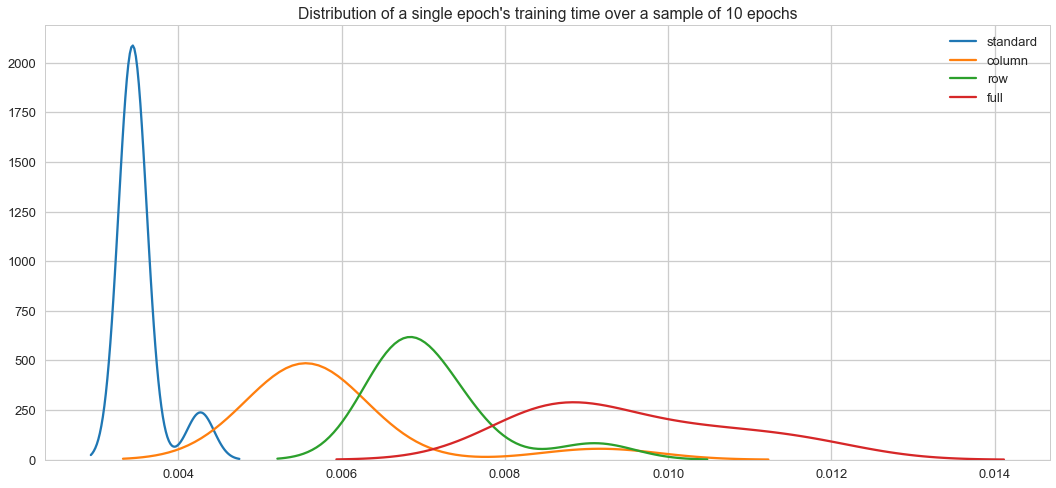

In [16]:
compare_network(n_samples=100, n_features=10, hidden_size=10)

As expected for this small dataset and number of hidden units, **the matrix sizes are too small for the parallel multiplications to be of any advantage**.

Let's see what happens when we **increase the number of features from 10 to 100** :

This machine has 4 CPUs


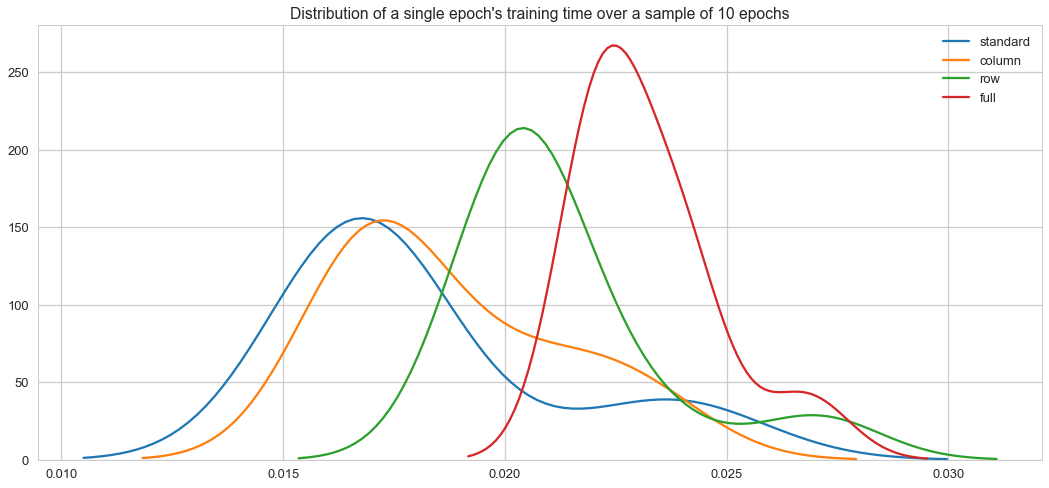

In [17]:
compare_network(n_samples=100, n_features=100, hidden_size=10)

As we've guessed before, **the parallel versions start catching up with the standard version** but we're still not really beating the baseline.

Now, let's **increase the hidden layer size from 10 to 100** and see if we manage to outperform this baseline.

This machine has 4 CPUs


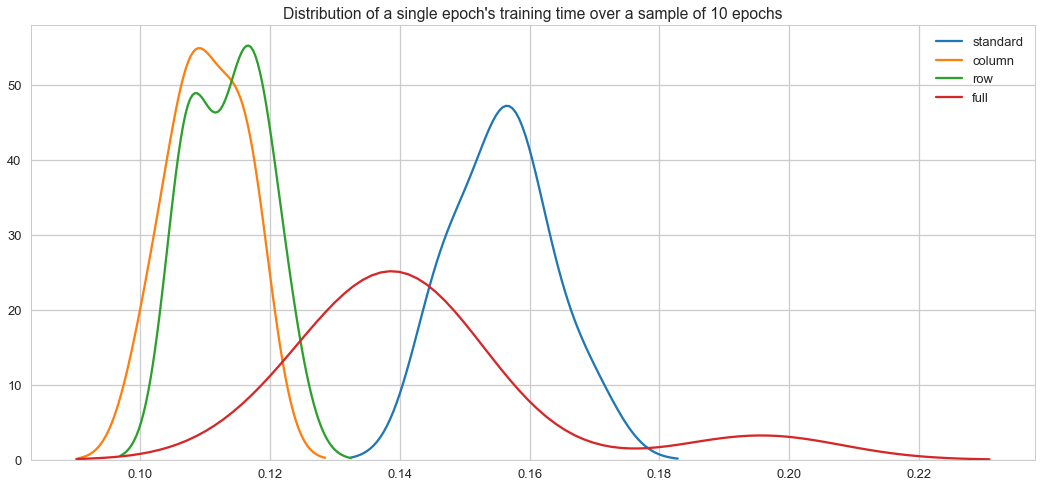

In [18]:
compare_network(n_samples=100, n_features=100, hidden_size=100)

At last, all parallel versions of the Neural Network seem to be (in most cases) **faster than the standard baseline**.

But does this still work if we, say, increase the hidden layer size **another magnitude of 10** ?

This machine has 4 CPUs


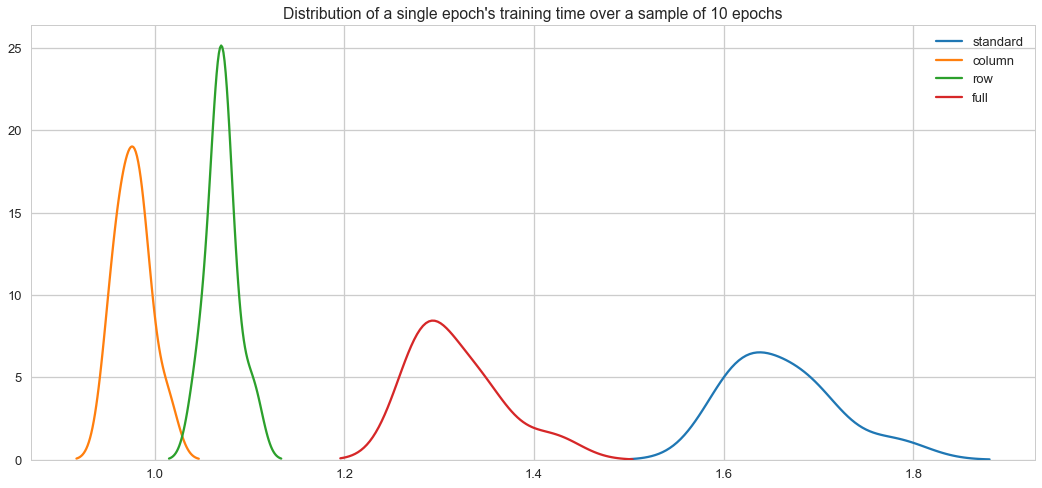

In [19]:
compare_network(n_samples=100, n_features=100, hidden_size=1000)

Great ! This finally proves that the parallel Neural Networks we created using very **simple parallelization schemes** can be **faster** in practice than a simple neural network. But in order to ensure that a parallel network will beat a standard one, the dimensions of **the network should be large enough** to offset the time that is lost spawning the several processes.

# Part II : Parallelizing the learning steps

Now that we've seen how we could go about parallelizing a Neural Network's computations to make it faster (and therefore learn faster), let's explore another option : **learn in parallel**. In practice, we are going to try to **learn on several subsets** of the data simultaneously and then do all **the weight updates** at once (we could also average them).

Let's add this feature to the previous NeuralNetwork class :

In [20]:
class NeuralNetwork_v2(NeuralNetwork):
    """Same as previous Neural Network but is able to run batches in parallel."""
    
    @staticmethod
    def multi_update(syn, deltas, update_mode):
        for i, row in enumerate(syn):
            for j, value in enumerate(row):
                if update_mode == "average":
                    N = len(deltas)
                    for delta in deltas:
                        syn[i][j] += delta[i][j]/N
                if update_mode == "sum":
                    for delta in deltas:
                        syn[i][j] += delta[i][j]

    @staticmethod
    def training_job(data, learning_rate, syn0, syn1, multiply):

        X, y = data

        l0 = []
        for row in X:
            l0.append(row + [1])

        l1 = sigmoid(np.dot(l0, syn0))
        l2 = sigmoid(np.dot(l1, syn1))

        l2_error = [
            [target[0] - activation[0]]
            for target, activation in zip(y, l2)
        ]
        l2_delta = [
            [learning_rate * error[i] * df[i] for i in range(len(df))]
            for error, df in zip(l2_error, sigmoid(l2, deriv=True))
        ]

        l1_error = multiply(l2_delta, transpose(syn1))
        l1_delta = [
            [learning_rate * error[i] * df[i] for i in range(len(df))]
            for error, df in zip(l1_error, sigmoid(l1, deriv=True))
        ]
        
        syn1_delta = multiply(transpose(l1), l2_delta)
        syn0_delta = multiply(transpose(l0), l1_delta)
        
        return syn0_delta, syn1_delta

    def train(self, X, y, learning_rate=1, n_batches=1,
              parallel=False, update_mode="average"):
        
        n_samples = len(X)
        splits = [(i * n_samples) // n_batches
                  for i in range(0, n_batches + 1)]
        
        sub_X = [X[i:j] for (i, j) in zip(splits[:-1], splits[1:])]
        sub_y = [y[i:j] for (i, j) in zip(splits[:-1], splits[1:])]

        if parallel:
            global pool
            partial_job = partial(self.training_job, 
                                  learning_rate=learning_rate,
                                  syn0=self.syn0, syn1=self.syn1,
                                  multiply=self.multiply)

            deltas = pool.map(partial_job, zip(sub_X, sub_y))
            syn0_delta = [delta[0] for delta in deltas]
            syn1_delta = [delta[1] for delta in deltas]

            self.multi_update(self.syn1, syn1_delta, update_mode)
            self.multi_update(self.syn0, syn0_delta, update_mode)
        
        else:
            
            for X, y in zip(sub_X, sub_y):
                # Add bias to input
                l0 = []
                for row in X:
                    l0.append(row + [1])

                l1 = sigmoid(np.dot(l0, self.syn0))
                l2 = sigmoid(np.dot(l1, self.syn1))

                # how much did we miss the target value?
                l2_error = [
                    [target[0] - activation[0]]
                    for target, activation in zip(y, l2)
                ]

                # in what direction is the target value?
                l2_delta = [
                    [learning_rate * error[i] * df[i] for i in range(len(df))]
                    for error, df in zip(l2_error, sigmoid(l2, deriv=True))
                ]

                # how much did each l1 value contribute to the l2 error?
                l1_error = self.multiply(l2_delta, transpose(self.syn1))

                # in what direction is the target l1?
                l1_delta = [
                    [learning_rate * error[i] * df[i] for i in range(len(df))]
                    for error, df in zip(l1_error, sigmoid(l1, deriv=True))
                ]

                # Update weights
                self.update(self.syn1, self.multiply(transpose(l1), l2_delta))
                self.update(self.syn0, self.multiply(transpose(l0), l1_delta))

Now, in order to compare a Neural Network that is learning in parallel to another that is not, we define a function that will create **2 copies of the same network** then train each copy on a number of batches either in parallel or not. During the training, the function will be keeping track of the **time** that took each epoch so that we are able to visualize in the end the evolution of the **MSE** along with the speed of each epoch.

In [21]:
def compare_network(n_samples, n_features, hidden_size,
                    n_batches, learning_rate, update_mode):

    np.random.seed(0)
    
    # Create a process pool
    global pool
    n_CPUs = mp.cpu_count()
    pool = mp.Pool(processes=n_CPUs)
    print("This machine has {} CPUs".format(n_CPUs))

    # Generate random regression data
    train_split = int(n_samples * 0.5)
    X, y = make_regression(n_samples=n_samples, n_features=n_features)
    y = ((y - y.min())/(y.max() - y.min())).reshape(-1, 1)
    X = X.tolist()
    y = y.tolist()

    # Base model to start from the same
    base_model = NeuralNetwork_v2(input_size=n_features,
                                  hidden_size=hidden_size,
                                  output_size=1)
    
    # Monitor the MSE and elapsed time
    times = defaultdict(list)
    metrics = defaultdict(list)
    for parallel in [False, True]:
        
        model = deepcopy(base_model)

        times[parallel].append(0)
        
        prediction = model.predict(X[train_split:])
        metrics[parallel].append(
            np.mean((np.array(y[train_split:]) - np.array(prediction))**2)
        )
        
        t = time.time()
        for _ in tqdm(range(10), desc="epoch"):
        
            model.train(X[:train_split], y[:train_split],
                        learning_rate=learning_rate, n_batches=n_batches,
                        parallel=parallel, update_mode=update_mode)

            times[parallel].append(time.time()-t)        
            
            prediction = model.predict(X[train_split:])
            metrics[parallel].append(
                np.mean((np.array(y[train_split:]) - np.array(prediction))**2)
            )
            
        plt.plot(times[parallel], metrics[parallel], marker='o',
                 label='parallel' if parallel else 'non-parallel')

    plt.xlabel("Elapsed time")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()
    
    pool.close()

#### Application :

We test both Neural Networks on a random regression dataset of **1000 samples**, **50 features** using a network with a **hidden layer of size 32** and learning on **20 mini-batches** at each epoch :

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

This machine has 4 CPUs


epoch: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


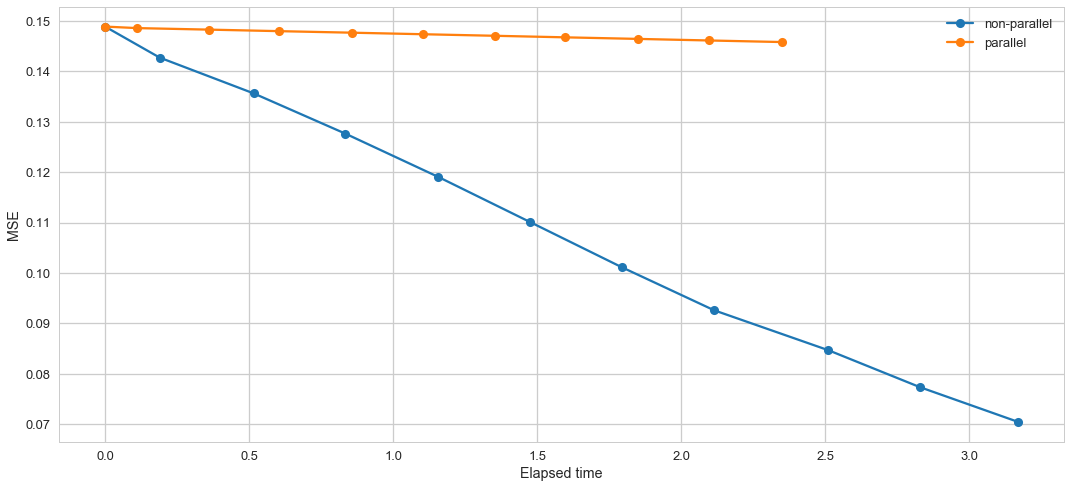

In [22]:
compare_network(1000, 50, 32, n_batches=20, learning_rate=0.1, update_mode="average")

We can see that the parallel version is indeed **faster** (the orange curve ends before the blue one). But there might be a problem : the standard network seem to be faster to converge and achieves a **lower MSE per epoch despite each epoch taking more time to complete** than the parallel version. This is due to the fact that after each batch is learned on, the standard network **immediately updates its weights** and then moves on to the next batch from that position. Conversely, the parallel version **computes many updates** then does an **average update** that only takes one step toward the most optimal direction. This means that this kind of parallelisation wouldn't be useful in all practical cases.

A possible solution could be to take a **complete step** toward the direction that is computed at each parallel batch without averaging all the updates :

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

This machine has 4 CPUs


epoch: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


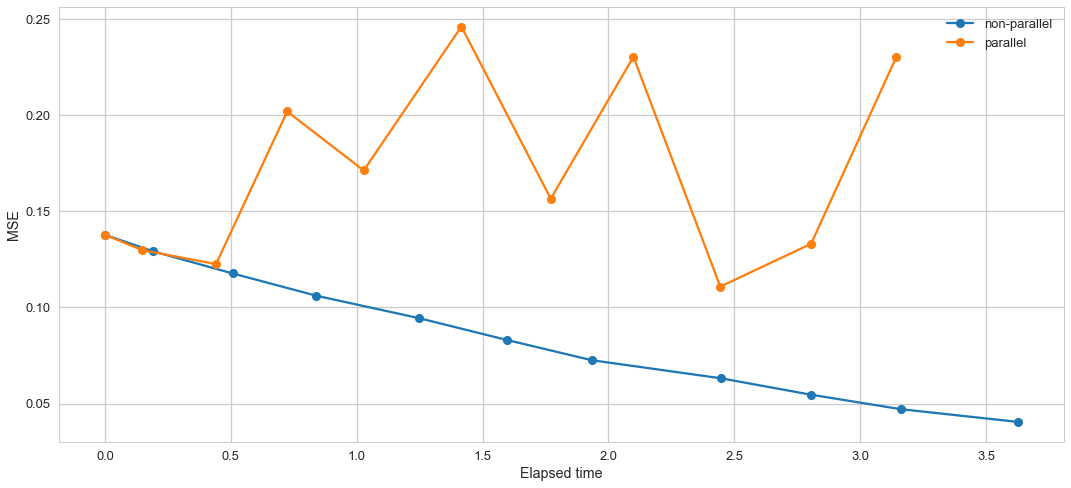

In [23]:
compare_network(1000, 50, 32, n_batches=20, learning_rate=0.1, update_mode="sum")

This doesn't seem to work, and **there is a reason for that**. Because we are adding all the updates together, the step we take toward the optimal weight can become **too big and miss this optimal solution**. This is the same problem that occurs when the **learning rate is too high**, therefore a possible solution is to **reduce the learning rate** so that every step is small anyway, preventing the parallel network from diverging :

This machine has 4 CPUs


epoch: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


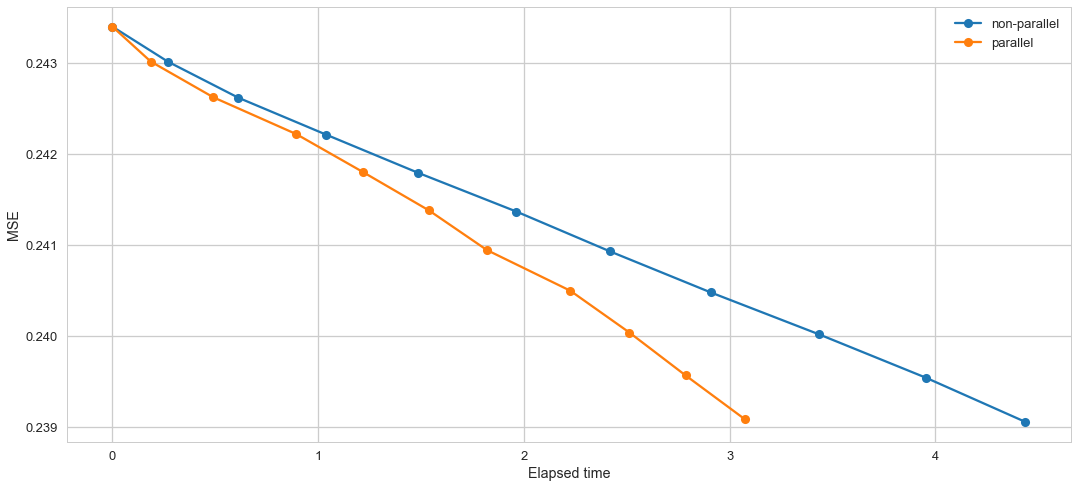

In [24]:
compare_network(1000, 50, 32, n_batches=20, learning_rate=0.001, update_mode="sum")

And there it is ! The Neural Network learning in parallel outperforms finally the standard baseline as the learning rate gets smaller. We have to keep in mind that we are only learning on 20 batches and that in order to choose a relevant learning rate we probably will have to make it smaller as the number of batches goes up.

# Conclusion

We have seen **two ways to use multiprocessing in order to improve a Neural Network**. The first way is to simply use each available process to do a part of the many computations that happen inside such a model by **parallelizing the matrix multiplication operation**. This method is useful when **the network is large** and when the learning is done **in large batches**. In fact, whenever the matrix multiplications weren't computationnaly intensive to begin with, the parallel version did poorly compared to the standard Neural Network. But when the conditions are right, the time that is saved this way can be used to further train the network possibly achieving a higher performance. The second method we saw focused directly on the training. Instead of making the network run faster, the plan here was to **simultaneously learn on many batches then carry out a single global update** that is based on each batch's update. The first intuition was to simply average all the updates, but this wasn't the best way to do it and performed poorly. The reason for this is probably because each time the parallel version took one step toward the optimal solution, the standard version took as many steps as there was batches, converging faster despite the direction of each step being probably less optimal. The solution was to **decrease the learning rate** and simply **sum over all the parallel updates**. Because the learning rate was low, the many steps taken in the parallel case didn't diverge and as the parallel network ran faster, **the overall convergence was best according to both the elapsed time and the metric (MSE)**.

All in all, the main results are :
- **If you are running a large network on large batch sizes, consider parallelizing the matrix multiplications**.
- **If you are learning on a large number of batches and the learning rate is low, consider learning on each batch in parallel and sum the updates**.